# Day 3: Multi-class Classification and Neural Networks

In this exercise, you will implement one-vs-all logistic regression and neural networks to recognize hand-written digits

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
plt.rcParams['figure.figsize'] = (13, 7)
import scipy.io # Load the OCTAVE *.mat files
from scipy.optimize import minimize # To minimize the theta
import scipy.misc # Show matrix as an image
import random # To pick random images to display
from scipy.special import expit # Vectorized Sigmoid function
from sklearn.linear_model import LogisticRegression # Logistic Regression built-in function

## 1 Multi-class Classification

For this exercise, you will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. This exercise will show you how the methods you’ve learned can be used for this classification task.

In the first part of the exercise, you will extend your previous implemention of logistic regression and apply it to one-vs-all classification.

### 1.1 Dataset

In [2]:
data = scipy.io.loadmat('data/ex3data1.mat')
print(data.keys())
X = np.c_[np.ones((data['X'].shape[0], 1)), data['X']]
y = data['y']
print(X.shape)
print(y.shape)
print('Unique elements in y: {}'.format(np.unique(y)))

dict_keys(['__version__', '__header__', '__globals__', 'X', 'y'])
(5000, 401)
(5000, 1)
Unique elements in y: [ 1  2  3  4  5  6  7  8  9 10]


### 1.2 Visualizing the data

In [3]:
def getDatumImg(row):
    """
    Function that is handed a single np array with shape 1x400,
    crates an image object from it, and returns it.
    """
    width, height = 20, 20
    square = row[1:].reshape(width, height)
    return square.T

def displayData(indices_to_display=None):
    """
    Function that picks 100 random rows from X, creates a 20x20 image from each,
    then stitches them together into a 10x10 grid of images, and shows it.
    """
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not indices_to_display:
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)
    
    big_picture = np.zeros((height*nrows, width*ncols))
    
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol = 0
        iimg = getDatumImg(X[idx])
        big_picture[irow*height:irow*height+iimg.shape[0], icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img = scipy.misc.toimage(big_picture)
    plt.imshow(img, cmap=cm.Greys_r)
    plt.xticks([])
    plt.yticks([])

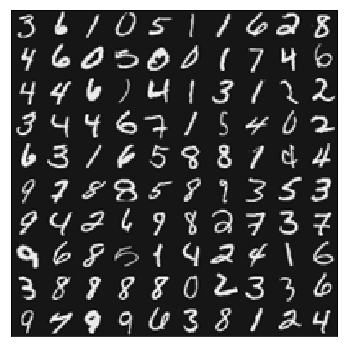

In [4]:
displayData()

### 1.3 Vectorizing Logistic Regression

In [5]:
def sigmoid(z):
    '''Implement Sigmoid function.'''
    return (1 / (1 + np.exp(-z)))

def h(theta, X):
    '''Hypothesis function using sigmoid function.
    Paramters:
        X: training set, which is matrix with m-rows and n-columns
        theta: parameters of the model, which is an n-vector
    Return: hypothesis value is m-vector.'''
    return sigmoid(np.dot(X, theta))

def lrcostFunctionReg(theta, lambd, X, y):
    '''Cost function in Regularized Logistic Regression.
    Parameters:
        theta: parameters of the model, which is an n-vector
        X: training set, which is matrix with m-rows and n-columns 
        y: target set, which is a matrix with m-rows and 1-columns
        lambd: regularization parameter, default = 0
    Return: J cost value is scalar.'''
    m = y.size
    h = sigmoid(np.dot(X, theta))
    
    term1 = np.dot(y.T, np.log(h))
    term2 = np.dot((1-y).T, np.log(1 - h))
    reg = (lambd/(2*m)) * np.sum(np.square(theta[1:]))
    return (-1/m) * (term1 + term2) + reg

def lrgradientReg(theta, lambd, X, y):
    '''Compute gradient descent of Regularized Logistic Regression.'''
    m = y.size
    h = sigmoid(np.dot(X, theta.reshape(-1, 1)))

    grad = (1/m) * X.T.dot(h-y) + (lambd/m) * np.r_[[[0]], theta[1:].reshape(-1, 1)]
    
    return (grad.flatten())

### 1.4 One-vs-all Classification

In [6]:
def oneVsAll(X, y, n_labels, lambd):
    '''Minimize theta parameters in one-vs-all Classification.'''
    initial_theta = np.zeros((X.shape[1], 1)) # 401x1
    all_theta = np.zeros((n_labels, X.shape[1])) # 10x401
    
    for c in np.arange(1, n_labels+1):
        res = minimize(lrcostFunctionReg, initial_theta, args=(lambd, X, (y==c)*1),
                       method=None, jac=lrgradientReg, options={'maxiter': 50})
        all_theta[c-1] = res.x
    return (all_theta)

In [7]:
theta = oneVsAll(X, y, 10, 0.1)

**1.4.1 One-vs-all Prediction**

In [8]:
def predictOneVsAll(all_theta, X):
    '''Predicting label in training set.'''
    probs = sigmoid(X.dot(all_theta.T))
        
    # Adding one because Python uses zero based indexing for the 10 columns (0-9),
    # while the 10 classes are numbered from 1 to 10.
    return(np.argmax(probs, axis=1)+1)

In [9]:
pred = predictOneVsAll(theta, X)
print('Training set accuracy: {} %'.format(np.mean(pred == y.ravel())*100))

Training set accuracy: 93.24 %


### 1.5 Multiclass Logistic Regression with scikit-learn

In [10]:
clf = LogisticRegression(C=10, penalty='l2', solver='liblinear')
# Scikit-learn fits intercept automatically, so we exclude first column with 'ones' from X when fitting.
clf.fit(X[:,1:],y.ravel())

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [11]:
pred2 = clf.predict(X[:,1:])
print('Training set accuracy: {} %'.format(np.mean(pred2 == y.ravel())*100))

Training set accuracy: 96.5 %


## 2 Neural Networks

### 2.1 Model representation

In [12]:
weights = scipy.io.loadmat('data/ex3weights.mat')
print(weights.keys())
theta1, theta2 = weights['Theta1'], weights['Theta2']
print('theta1: {}'.format(theta1.shape))
print('theta2: {}'.format(theta2.shape))

dict_keys(['Theta1', '__version__', '__header__', '__globals__', 'Theta2'])
theta1: (25, 401)
theta2: (10, 26)


### 2.2 Feedforward Propagation and Prediction

In [13]:
def predict(theta_1, theta_2, X):
    z2 = theta_1.dot(X.T)
    a2 = np.c_[np.ones((data['X'].shape[0],1)), sigmoid(z2).T]
    
    z3 = a2.dot(theta_2.T)
    a3 = sigmoid(z3)
        
    return(np.argmax(a3, axis=1)+1) 

In [14]:
pred = predict(theta1, theta2, X)
print('Training set accuracy: {} %'.format(np.mean(pred == y.ravel())*100))

Training set accuracy: 97.52 %
